# Context
This is the dataset that is used for the paper " A data-driven approach to predict the success of bank telemarketing ".

IMHO it's a good dataset for training oneself in M.L. by building one classifier. After you can compare your results with the paper.

# Content
Input variables:

#### bank client data:

- age (numeric) 
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown') 
- loan: has personal loan? (categorical: 'no','yes','unknown')

#### related with the last contact of the current campaign:

- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
- dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

#### other attributes:

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

#### social and economic context attributes

- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

#### Output variable (desired target):

- y - has the client subscribed a term deposit? (binary: 'yes','no')

# Citation Request (Acknowledgements)
This dataset is public available for research. The details are described in [Moro et al., 2014].
Please include this citation if you plan to use this database:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from matplotlib import rcParams
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score
# import xgboost as xgb, XGBClassifier
from xgboost import XGBClassifier
import statsmodels.formula.api as smf
%matplotlib inline

rcParams['figure.figsize'] = 17,10

In [32]:
df = pd.read_csv("bank-additional.csv")
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4114,30,admin.,married,basic.6y,no,yes,yes,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
4115,39,admin.,married,high.school,no,yes,no,telephone,jul,fri,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.959,5228.1,no
4116,27,student,single,high.school,no,no,no,cellular,may,mon,...,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
4117,58,admin.,married,high.school,no,no,no,cellular,aug,fri,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no


In [33]:
def plot_graphs(col, df):
    # Set Figsize
    if len(df[col].value_counts()) > 5:
        fig, ax = plt.subplots(2, sharex=True, figsize=(10, 10))
    else:
        fig, ax = plt.subplots(1, 2, figsize=(7, 5))
        fig.tight_layout()

    # Plot Histogram
    sns.countplot(data=df, x=col, ax=ax[0], color='C0')
    for i, p in enumerate(ax[0].patches):
        ax[0].annotate(f'{p.get_height()}', (p.get_x()+0.1, p.get_height()+5))
    ax[0].set_title(f"{col.title()} Histogram")
    # ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")

    # Plot y distribution on feature
    Y = df[col]
    total = len(Y)
    sns.countplot(x=col, data=df, hue="y")
    for i, p in enumerate(ax[1].patches):
        percent = (p.get_height() / total) * 100
        ax[1].annotate(f'{percent:.2f}%', (p.get_x()+0.1, p.get_height()+5))

    ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=10, ha="right")
    ax[1].set_title(f"y distribution on {col.title()}")
    plt.show()
    # fig.savefig(f'bank-telemarketing-prediction/images/hist_{col}.png')
    # plt.close(fig)

In [34]:
numerics = df.select_dtypes(include=np.number).columns.tolist()
categorical = [col for col in df.columns if col not in numerics]

cat job


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


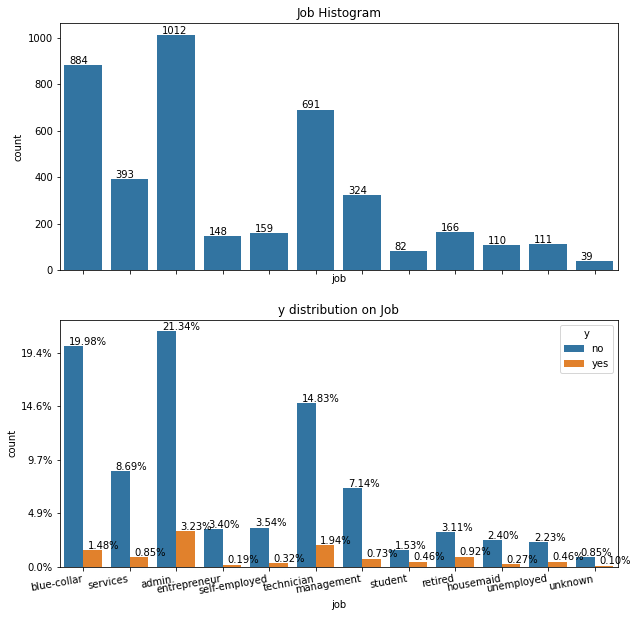

cat marital


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


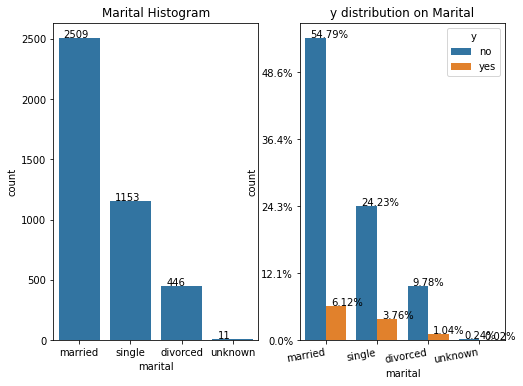

cat education


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


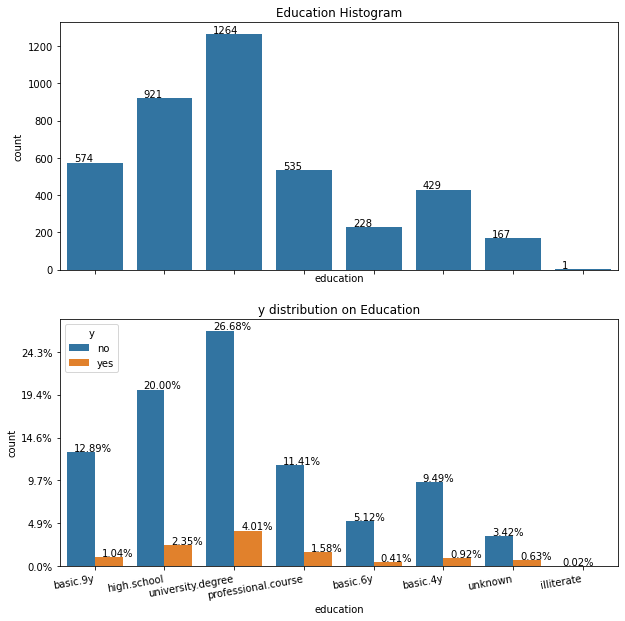

cat default


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


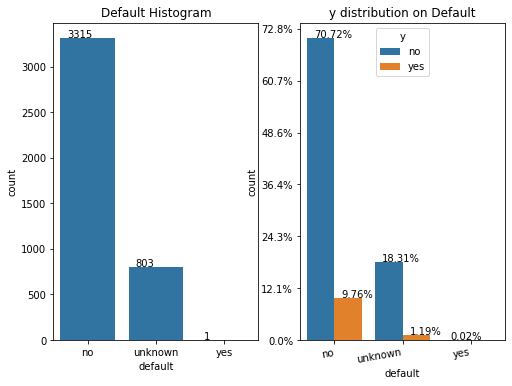

cat housing


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


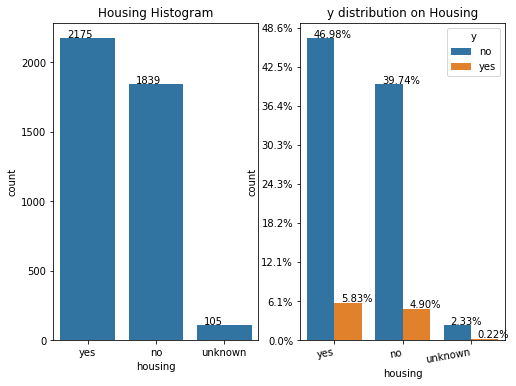

cat loan


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


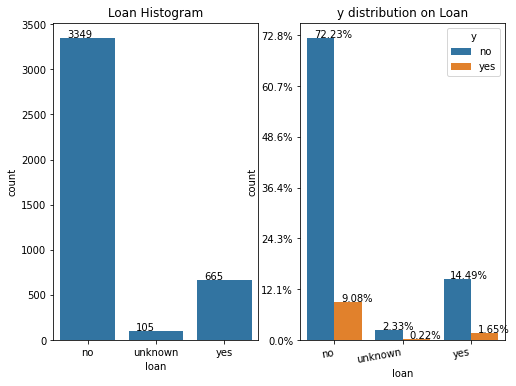

cat contact


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


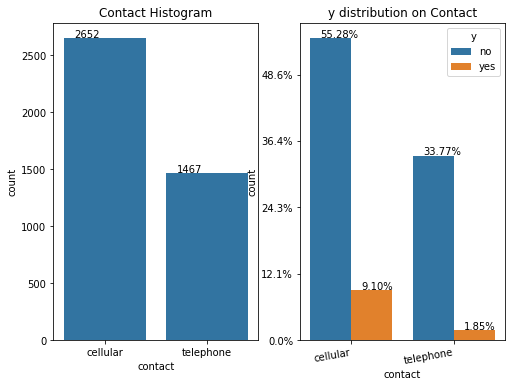

cat month


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


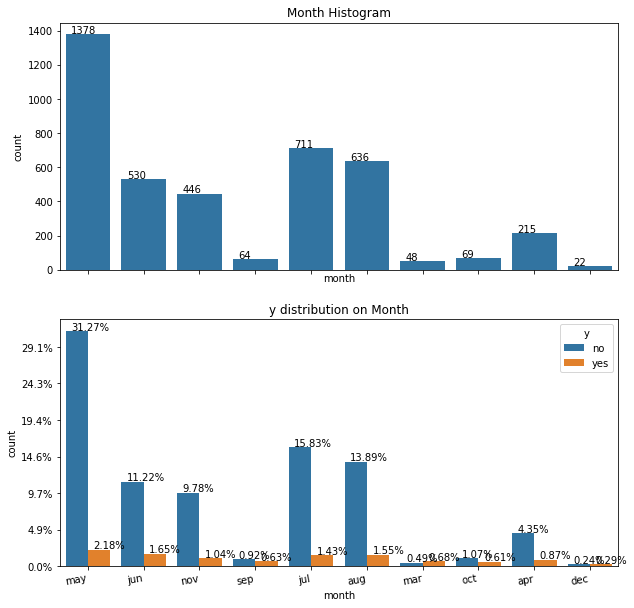

cat day_of_week


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


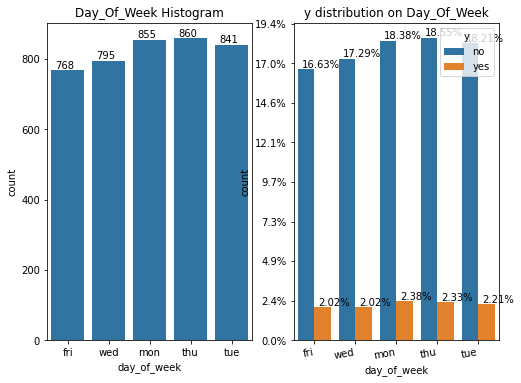

cat poutcome


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


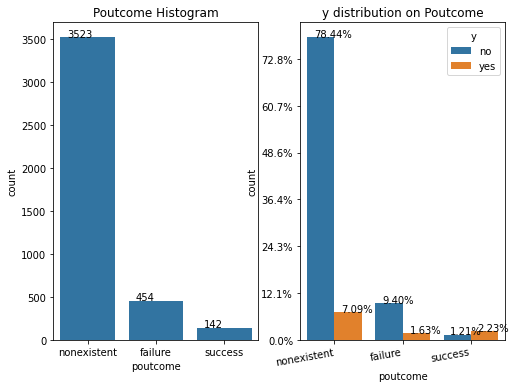

cat y


/var/folders/71/7j1whvnj7tzg96g8jklhj8840000gn/T/ipykernel_10915/49774374.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(map('{:.1f}%'.format, 100*ax[1].yaxis.get_majorticklocs()/total))


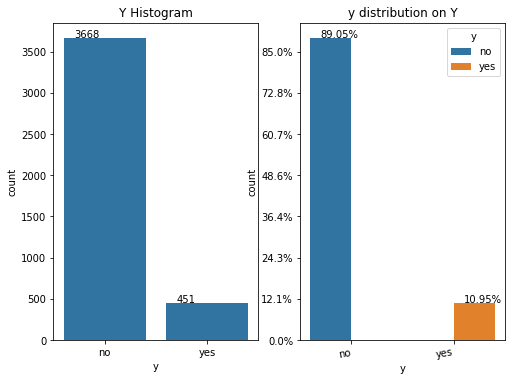

In [35]:
for cat in categorical:
    print('cat', cat)
    plot_graphs(cat, df)


In [36]:
def plot_numeric_graphs(col, df):
    fig, ax = plt.subplots(2, figsize=(7, 10))
    sns.boxplot(x='y', y=col, data=df, ax=ax[0])
    sns.histplot(df[col], kde=True)
    plt.show()
    # fig.savefig(f'bank-telemarketing-prediction/images/hist_{col.replace(".", "_")}.png')
    # plt.close(fig)

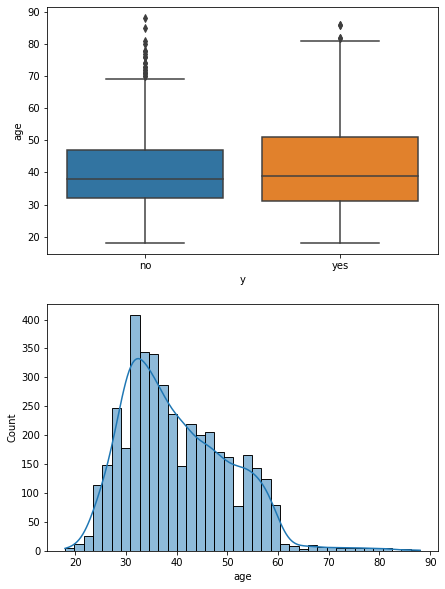

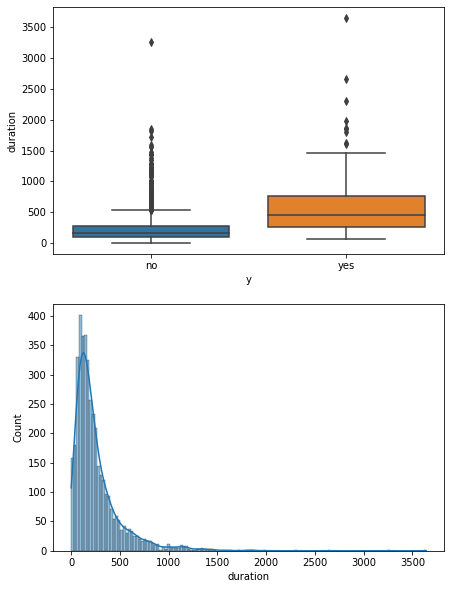

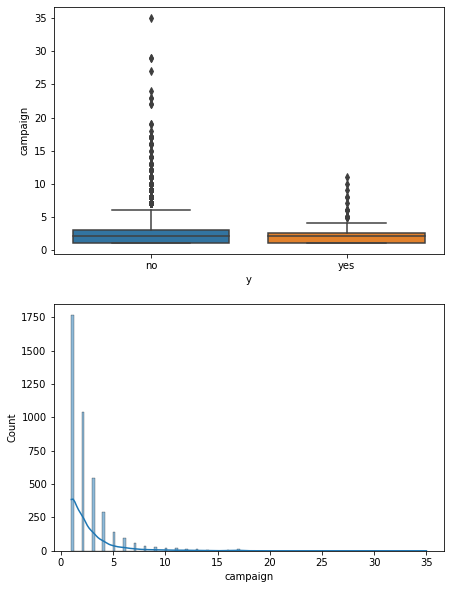

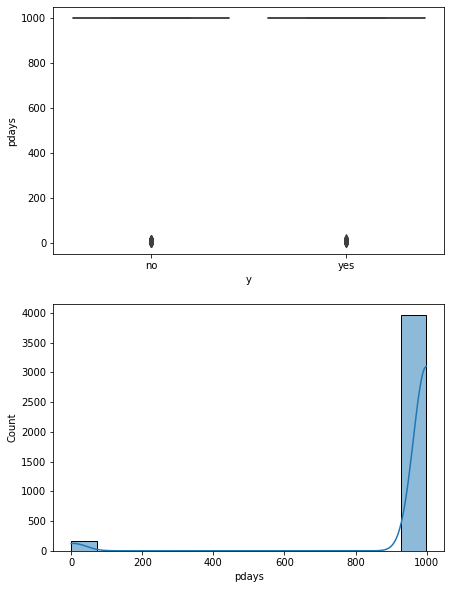

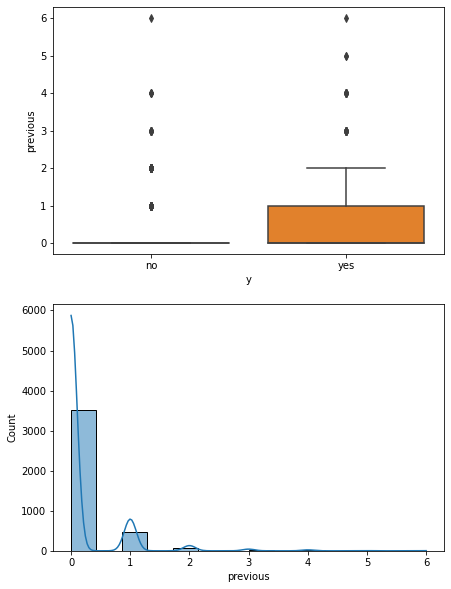

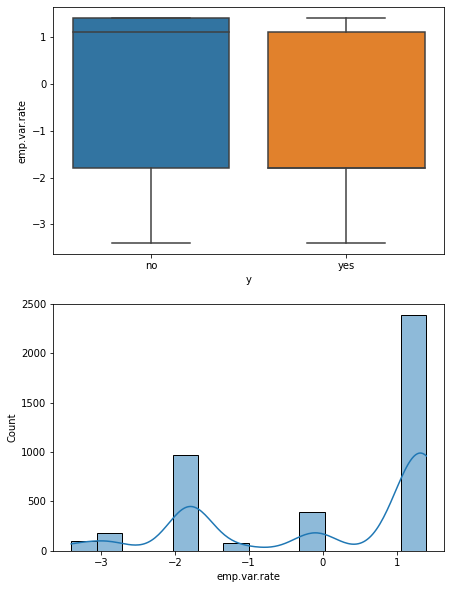

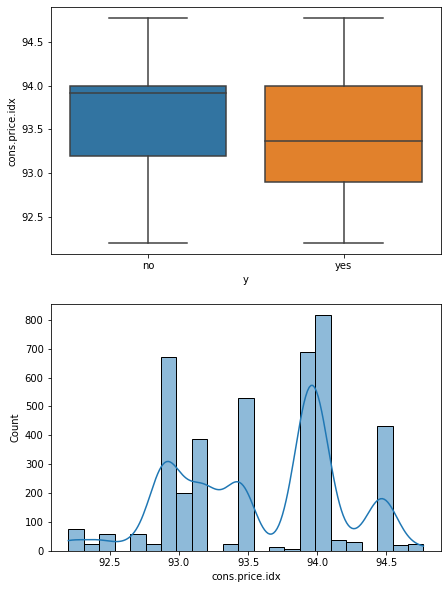

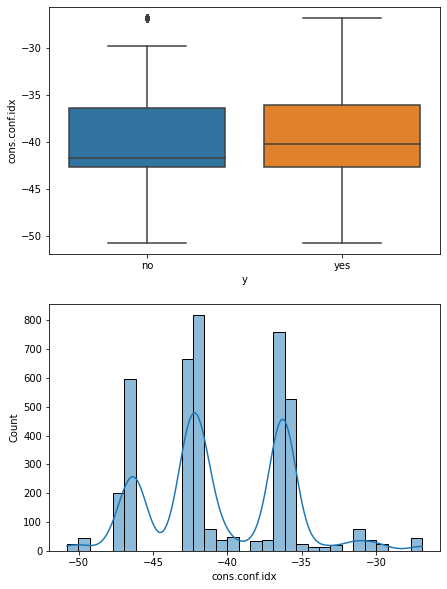

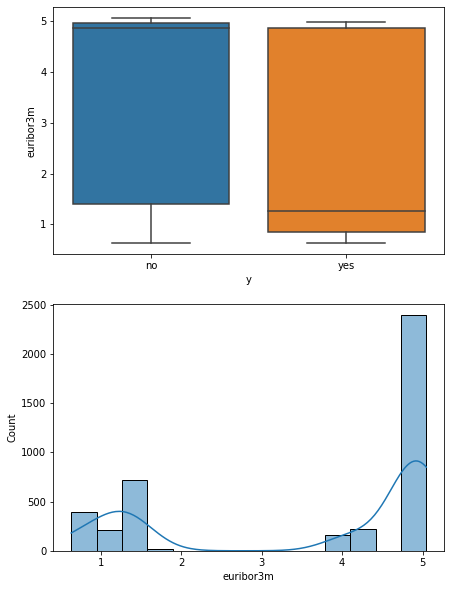

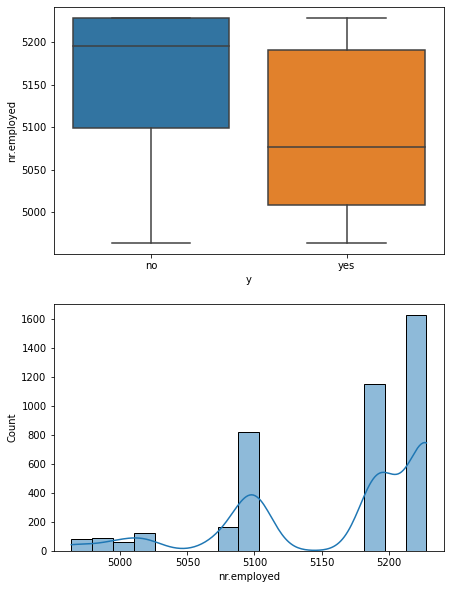

In [37]:
for num in numerics:
    plot_numeric_graphs(num, df)

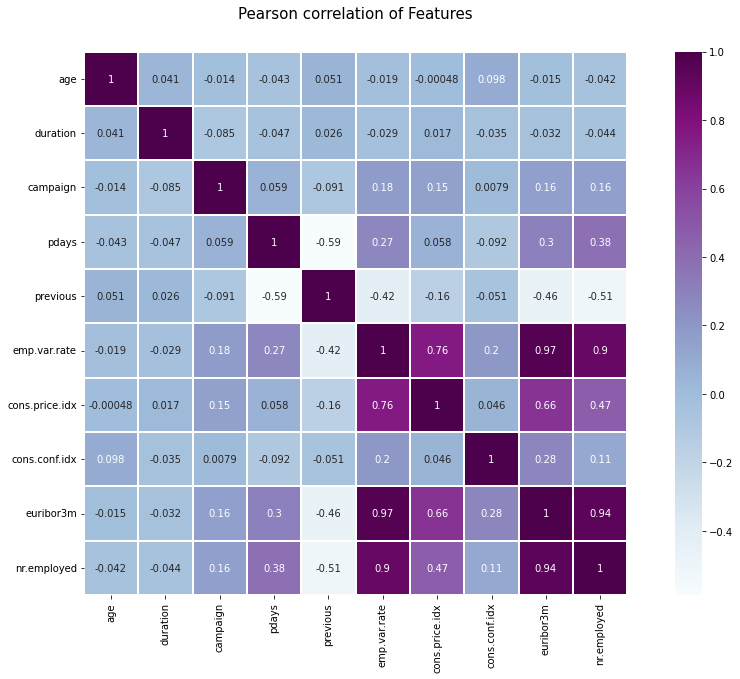

In [38]:
sns.heatmap(df.corr(), cmap="BuPu", square=True, annot=True, linewidth=0.1)
plt.title("Pearson correlation of Features", y=1.05, size=15)
plt.show()
# plt.savefig('bank-telemarketing-prediction/images/heatmap_corr.png')

In [39]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [40]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [41]:
df_dummy = pd.get_dummies(df, columns=categorical)
df_dummy['y'] = df_dummy.y.map({'yes': 1, 'no': 0})

In [42]:
X = df_dummy.drop(columns=['y'])
y = df_dummy.y.values
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.33, random_state=12)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2759, 63)
(1360, 63)
(2759,)
(1360,)


AUC score with duration column:  0.9327543635589612
AUC score without duration column:  0.7521668795232013


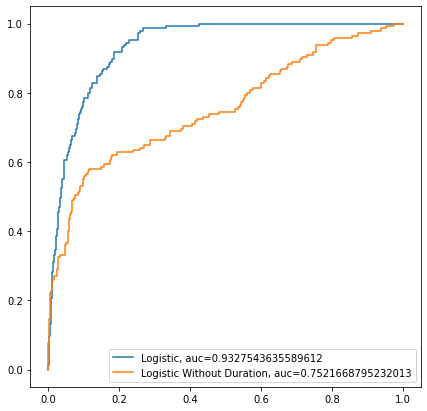

In [43]:
model = LogisticRegression(class_weight='balanced', max_iter=10000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print("AUC score with duration column: ", auc)
fpr, tpr, _ = roc_curve(y_test,  y_pred)

X_train_drop = X_train.drop(columns=["duration"])
X_test_drop = X_test.drop(columns=["duration"])

model = LogisticRegression(class_weight='balanced', max_iter=10000)
model.fit(X_train_drop, y_train)
y_pred_without_dur = model.predict_proba(X_test_drop)[:,1]
auc2 = roc_auc_score(y_test, y_pred_without_dur)
print("AUC score without duration column: ", auc2)
fpr2, tpr2, _ = roc_curve(y_test,  y_pred_without_dur)

plt.figure(figsize=(7,7))
plt.plot(fpr, tpr , label="Logistic, auc="+str(auc))
plt.plot(fpr2, tpr2 , label="Logistic Without Duration, auc="+str(auc2))
plt.legend(loc=4)
plt.show()

k = 1e-05, AUC = 0.6810330637150559
k = 0.0001, AUC = 0.7618334042855115
k = 0.001, AUC = 0.7562253441180644
k = 0.01, AUC = 0.7549595572584078
k = 0.1, AUC = 0.7523258124024409
k = 1, AUC = 0.7521668795232013
k = 10, AUC = 0.7530239818362425
k = 100, AUC = 0.7517127855825173
k = 1000, AUC = 0.7530296580105009


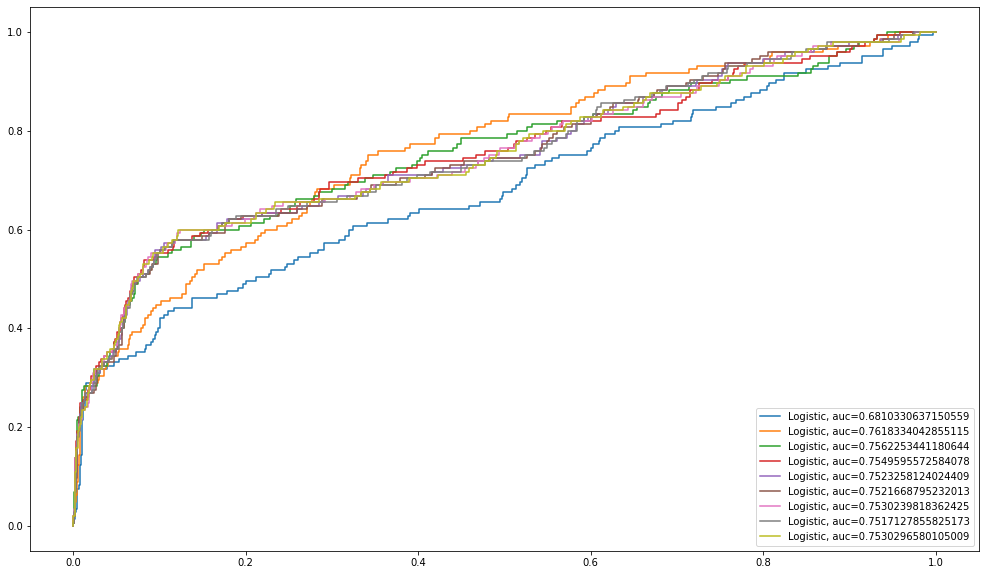

Best Alpha = 0.0001
Best AUC Score = 0.7618334042855115


In [44]:
alpha = [10 ** x for x in range(-5, 4)]
auc_results = []
for a in alpha:
    model_log_reg = LogisticRegression(penalty='l2', C=a, class_weight='balanced', max_iter=10000)
    model_log_reg.fit(X_train_drop, y_train)
    y_pred = model_log_reg.predict_proba(X_test_drop)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    print(f"k = {a}, AUC = {auc}")
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    plt.plot(fpr, tpr , label="Logistic, auc="+str(auc))
    plt.legend(loc=4)
    auc_results.append(roc_auc_score(y_test, y_pred))
plt.show()
best_alpha_index = np.argmax(auc_results)
best_alpha = alpha[best_alpha_index]
print(f"Best Alpha = {best_alpha}")
print(f"Best AUC Score = {auc_results[best_alpha_index]}")

top_10 [ 6  3 50 43 42  0  4  1  7  5]


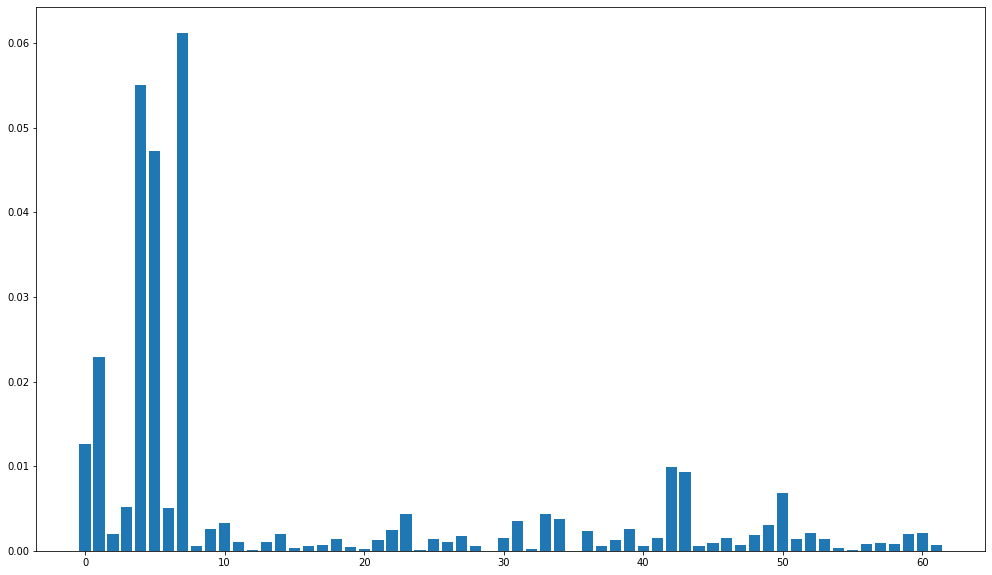

euribor3m
emp.var.rate
cons.price.idx
campaign
age
contact_cellular
contact_telephone
month_may
previous
cons.conf.idx


In [46]:
a = 0.0001
best_model_log_reg = LogisticRegression(penalty='l2', C=a, class_weight='balanced', max_iter=10000)
best_model_log_reg.fit(X_train_drop, y_train)
y_pred = best_model_log_reg.predict_proba(X_test_drop)[:,1]

importances = abs(best_model_log_reg.coef_[0])
top_10 = np.argpartition(importances, -10)[-10:]
print("top_10", top_10)
plt.bar([x for x in range(len(importances))], importances)
plt.show()
important_features = [(t, importances[t], X_train_drop.columns[t]) for t in top_10]
sorted_by_second = sorted(important_features, key=lambda tup: tup[1], reverse=True)
for s in sorted_by_second:
    print(s[2])

k = 10, AUC = 0.6821512700439903
k = 50, AUC = 0.7394919824038598
k = 100, AUC = 0.7437519511849014
k = 500, AUC = 0.7453299276287781
k = 1000, AUC = 0.7440726550305095
k = 2000, AUC = 0.7440613026819922


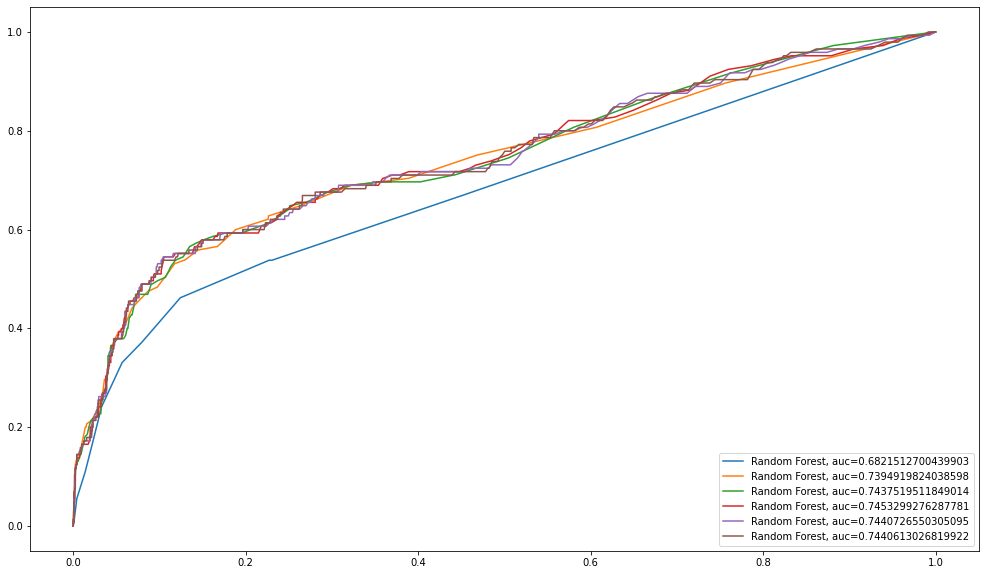

Best n = 500
Best AUC Score = 0.7453299276287781


In [47]:
alpha = [10, 50, 100, 500, 1000, 2000]
auc_results = []
for a in alpha:
    model_rand_forest = RandomForestClassifier(n_estimators=a, random_state=40, n_jobs=-1)
    model_rand_forest.fit(X_train_drop, y_train)
    y_pred = model_rand_forest.predict_proba(X_test_drop)[:,1]
    auc = roc_auc_score(y_test, y_pred)
    print(f"k = {a}, AUC = {auc}")
    fpr, tpr, _ = roc_curve(y_test,  y_pred)
    plt.plot(fpr, tpr , label="Random Forest, auc="+str(auc))
    plt.legend(loc=4)
    auc_results.append(roc_auc_score(y_test, y_pred))
plt.show()
best_alpha_index = np.argmax(auc_results)
best_alpha = alpha[best_alpha_index]
print(f"Best n = {best_alpha}")
print(f"Best AUC Score = {auc_results[best_alpha_index]}")



top_10_index [31  9  1  2  6  5  4  8  7  0]


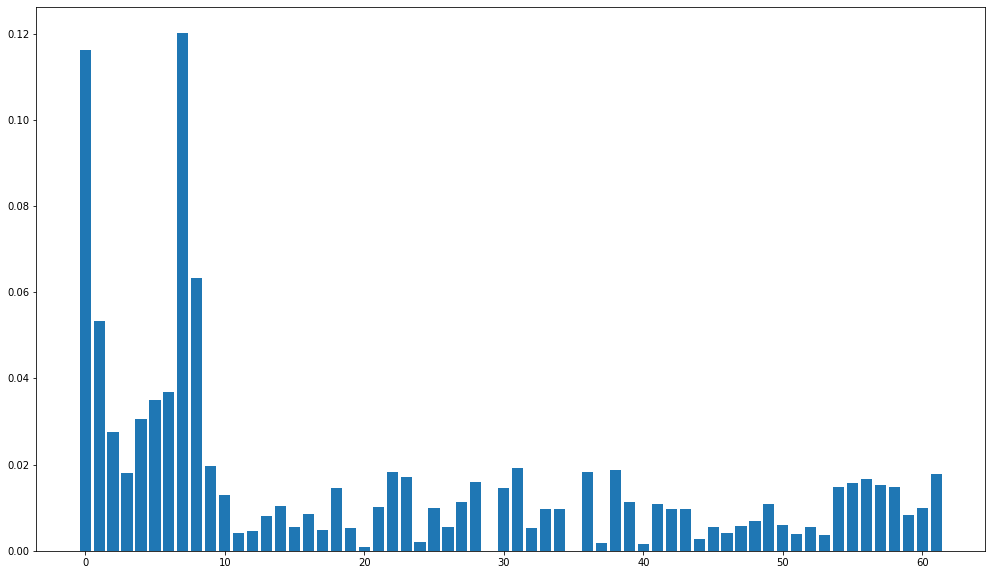

euribor3m
age
nr.employed
campaign
cons.conf.idx
cons.price.idx
emp.var.rate
pdays
job_admin.
education_university.degree


In [49]:
a = 500
best_model_rand_forest = RandomForestClassifier(n_estimators=a, random_state=40, n_jobs=-1)
best_model_rand_forest.fit(X_train_drop, y_train)
y_pred = best_model_rand_forest.predict_proba(X_test_drop)[:,1]

importances = best_model_rand_forest.feature_importances_
top_10 = np.argpartition(importances, -10)[-10:]
print("top_10_index", top_10)
plt.bar([x for x in range(len(importances))], importances)
plt.show()
important_features = [(t, importances[t], X_train_drop.columns[t]) for t in top_10]
sorted_by_second = sorted(important_features, key=lambda tup: tup[1], reverse=True)
for s in sorted_by_second:
    print(s[2])